### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [4]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

### Micrograd Classes and Functions

In [6]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [7]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [8]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

### Neural Network Neuron
<!-- ### Simple Neural Network: Single Neuron with 3 Inputs -->
<img src="..\karpathy\img\neural_network_single_neuron.png">

### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Example of Neural Network Matrix Operations: Outputs = Weights * Inputs + Bias
    input layer:          2 nodes, 2 sets of inputs
    hidden layer:         3 nodes
    output layer:         3 nodes, 2 sets of outputs
    activation function:  None

<img src="..\karpathy\img\Neural Network Matrix Operations for Visual Learner.png">

In [9]:
#######################################

### Introduction of Artificial Neural Network (ANN)
<img src="..\karpathy\img\neuron_of_human_brain_.3.png">

A neural network is a machine learning model inspired by the human brain.

### Neural Network Neuron

<img src="..\karpathy\img\neural_network_single_neuron_bard.png">

Neurons are the basic unit of the nervous system. They receive signals from other neurons and send signals to other neurons. The output of an artificial neural network (ANN) neuron is determined by the weighted sum of its inputs and a bias, then passed through an activation function.

The equation for the ANN neuron in the above image is:

output = activation(w0x0 + w1x1 + w2x2 + b)

where:

* output is the output of the neuron
* activation is the activation function
* w0, w1, and w2 are the weights
* x0, x1, and x2 are the inputs
* b is the bias

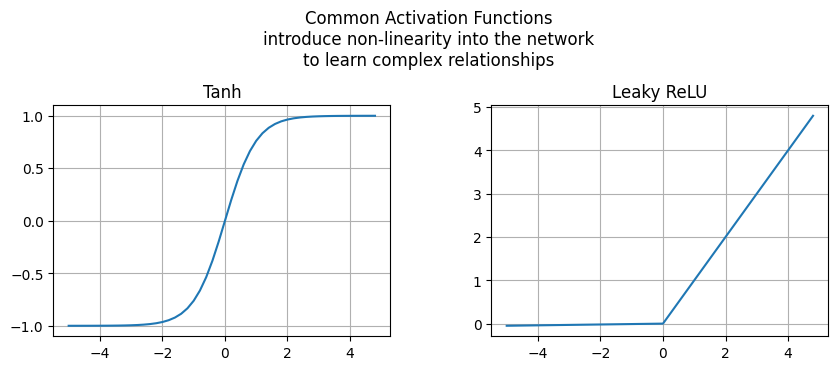

In [124]:
x = np.arange(-5, 5, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(x, np.tanh(x))
ax1.set_title("Tanh")
ax1.grid()

a = x[x < 0]*0.01
b = x[x >= 0]
y = np.concatenate((a, b))
ax2.grid()
ax2.plot(x, y)
ax2.set_title("Leaky ReLU")

plt_title = "Common Activation Functions\nintroduce non-linearity into the network\nto learn complex relationships"
plt.suptitle(plt_title , fontsize=12, y=1.2)
plt.subplots_adjust(wspace=0.3)
plt.show()

### Calculate Output with Forward Pass: tanh(x0\*w0 + x1\*w1 + x2\*w2 + b)

<img src="..\karpathy\img\Nertual_Network_1_Neuron_3_Inputs.png">

In [139]:
# inputs
x0 = Value(-3.0, label='x0')
x1 = Value(0.0, label='x1')
x2 = Value(0.5, label='x2')

# weights
w0 = Value(2.0, label='w0')
w1 = Value(1.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(4.618626415, label='b')

# forward pass: x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_0 = n.tanh(); out_0.label = 'out_0'
print(f'neuron output: {out_0.data}')

neuron output: -0.7071067801767762


##### Calculate Gradient with Backward Pass

w0.grad, d(output)/d(w0): -1.500000004284097


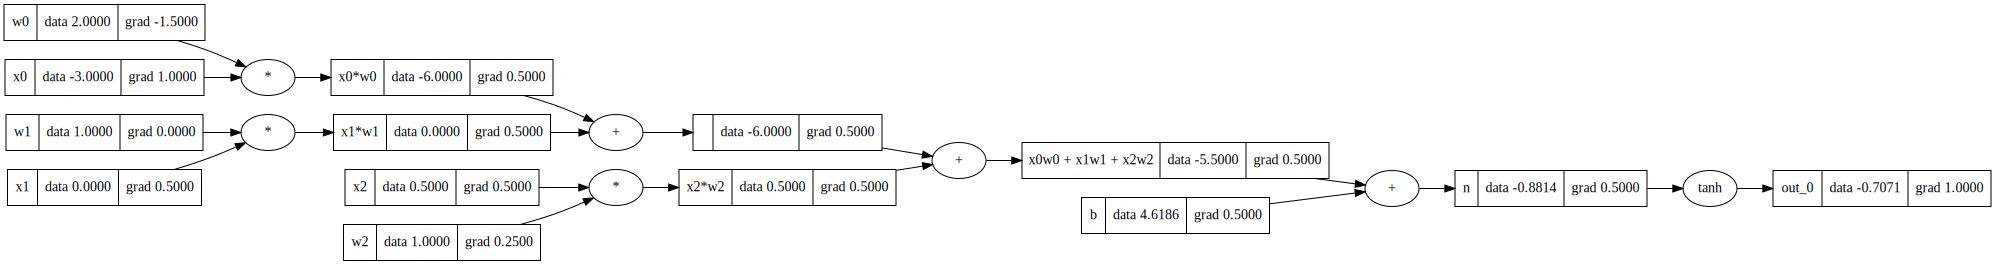

In [140]:
# backward pass to calculate gradient
out_0.backward()
  
out_0_grad = w0.grad  # store w0.grad, further calculation with w0 will reset w0.grad to zero
# print(f'w0.grad(i.e. d(output)/d(w0)): {w0.grad}')
print(f'w0.grad, d(output)/d(w0): {w0.grad}')
draw_dot(out_0)

### Math Operations in a Simple Neural Network

<img src="..\karpathy\img\Neural Network Matrix Operations_.5.png">

A simple neural network with two inputs (X1 and X2), three hidden neurons, and three outputs (Y1, Y2, and Y3). For example, X1 and X2 could represent the pixels of an image of a cat. Two sets of inputs are shown, each with different shades of gray (e.g., two images of cats). The outputs, Y1, Y2, and Y3, could represent the colors of the cat (e.g., white, black, or brown).

##### Calculate Output with Forward Pass: tanh(x0\*w0 + x1\*w1 + x2\*w2 + b)

In [138]:
# inputs
x1 = Value(0.0, label='x1')
x2 = Value(0.5, label='x2')

# weights
w1 = Value(1.0, label='w1')
w2 = Value(1.0, label='w2')
w3 = Value(2.0, label='w3')

# bias
b = Value(4.618626415, label='b')

# forward pass: x0*w0 + x1*w1 + x2*w2 + b
# x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
# x3w3 = x3*w3; x3w3.label = 'x3*w3'
n_sum = x1w1 + x2w2; n_sum.label = 'x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_0 = n.tanh(); out_0.label = 'out_0'
print(f'neuron output: {out_0.data}')

neuron output: 0.9999283803771857


In [133]:
# inputs
x0 = Value(-3.0, label='x0')
x1 = Value(0.0, label='x1')
x2 = Value(0.5, label='x2')

# weights
w0 = Value(2.0, label='w0')
w1 = Value(1.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(4.618626415, label='b')

# forward pass: x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_0 = n.tanh(); out_0.label = 'out_0'
print(f'neuron output: {out_0.data}')

neuron output: -0.7071067801767762


##### Calculate Gradient with Backward Pass

w0.grad, d(output)/d(w0): -1.500000004284097


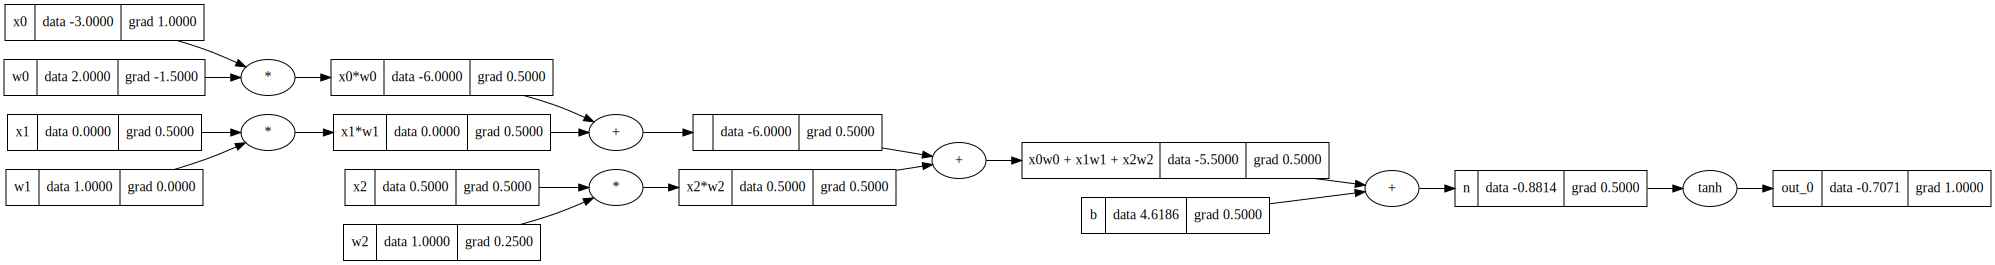

In [134]:
# backward pass to calculate gradient
out_0.backward()
  
out_0_grad = w0.grad  # store w0.grad, further calculation with w0 will reset w0.grad to zero
# print(f'w0.grad(i.e. d(output)/d(w0)): {w0.grad}')
print(f'w0.grad, d(output)/d(w0): {w0.grad}')
draw_dot(out_0)

##### Check Backward Pass Gradient Calculation: d(output) / d(x0)

In [135]:
h = 0.000001
w0 += h  # increment w0 by h

# x0*w0 + x1*w1 + x2*w2 + b
x0w0 = x0*w0; x0w0.label = 'x0*w0'
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
n_sum = x0w0 + x1w1 + x2w2; n_sum.label = 'x0w0 + x1w1 + x2w2'
n = n_sum + b; n.label = 'n'
out_1 = n.tanh(); out_1.label = 'out_1'
out_grad = (out_1 - out_0) / h 

print(f'---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----')
print(f'out_1: {out_1.data:<12.10f}, out_0: {out_0.data:<12.10f}, d(out): {out_1.data-out_0.data:<12.10f}, d(w0): {h:<12.10f}, d(out)/d(w0): {(out_1.data-out_0.data)/h:<12.10f}')
print(f'd(out) / d(w0):             {out_grad.data:<12.10f}')
print(f'w0.grad from backward pass: {out_0_grad:<12.10f}')

---- w0.grad from backward pass is same as d(out)/d(w0) calculation ----
out_1: -0.7071082802, out_0: -0.7071067802, d(out): -0.0000015000, d(w0): 0.0000010000, d(out)/d(w0): -1.4999968224
d(out) / d(w0):             -1.4999968224
w0.grad from backward pass: -1.5000000043


##### Check Output and Gradient Calculation with PyTorch

In [136]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Example of Neural Network Matrix Operations: Outputs = Weights * Inputs + Bias
    input layer:          2 nodes, 2 sets of inputs
    hidden layer:         3 nodes
    output layer:         3 nodes, 2 sets of outputs
    activation function:  None

<img src="..\karpathy\img\Neural Network Matrix Operations for Visual Learner.png">

### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [137]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

TypeError: __init__() takes 1 positional argument but 3 were given

In [ ]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,   0.3747506592
i:  1,   0.8622422536
i:  2,  -0.4805649008
i:  3,   0.5181578849
i:  4,  -0.8868411033
---
i: 36,  -0.5957718327
i: 37,   0.9416188972
i: 38,   0.8863146902
i: 39,  -0.9812273576
i: 40,   0.2413132959


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [ ]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [ ]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0:  0.3747507,   w0.grad:  0.0000000
w1:  0.8622423,   w1.grad:  0.0000000
w2: -0.4805649,   w2.grad:  0.0000000
b:   0.5181579

layer: 0, neuron 1
w0: -0.8868411,   w0.grad:  0.0000000
w1: -0.1914808,   w1.grad:  0.0000000
w2: -0.9143960,   w2.grad:  0.0000000
b:   0.6694719

layer: 0, neuron 2
w0: -0.7505029,   w0.grad:  0.0000000
w1: -0.8076541,   w1.grad:  0.0000000
w2: -0.8813307,   w2.grad:  0.0000000
b:  -0.0258581

layer: 0, neuron 3
w0:  0.3813281,   w0.grad:  0.0000000
w1:  0.3020627,   w1.grad:  0.0000000
w2:  0.0946822,   w2.grad:  0.0000000
b:   0.0777441

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0: -0.7253135,   w0.grad:  0.0000000
w1:  0.3137497,   w1.grad:  0.0000000
w2:  0.7777886,   w2.grad:  0.0000000
w3: -0.6947846,   w3.grad:  0.0000000
b:  -0.9195809

layer: 1, neuron 1
w0: -0.8957324,   w0.grad:  0.0000000
w1: -0.6369187,   w1.grad:  0.0000000
w2: -0.5132075,   w2.grad:  0.0000000
w3:  

##### Print Neural Network's Weights and Biases Matrices

In [ ]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[ 0.37475066  0.86224225 -0.4805649 ]
 [-0.8868411  -0.19148084 -0.91439601]
 [-0.75050293 -0.80765413 -0.88133069]
 [ 0.38132805  0.30206271  0.09468216]]
b_mat(1, 4):
[[ 0.51815788  0.66947193 -0.02585814  0.07774411]]

i: 1
w_mat(4, 4):
[[-0.7253135   0.31374966  0.7777886  -0.69478457]
 [-0.8957324  -0.63691865 -0.51320752  0.43287822]
 [ 0.53135618 -0.93907991 -0.8954387   0.39345217]
 [ 0.0683334  -0.5949127   0.53031187  0.95679619]]
b_mat(1, 4):
[[-0.9195809   0.01939265  0.68094115 -0.53049565]]

i: 2
w_mat(1, 4):
[[-0.59577183  0.9416189   0.88631469 -0.98122736]]
b_mat(1, 1):
[[0.2413133]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [ ]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[ 0.37475066  0.86224225 -0.4805649 ]
 [-0.8868411  -0.19148084 -0.91439601]
 [-0.75050293 -0.80765413 -0.88133069]
 [ 0.38132805  0.30206271  0.09468216]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[ 3.81679298  0.02172727]
 [-1.4337287  -2.92624048]
 [-3.04263757 -1.88452   ]
 [ 1.57416208  0.88926253]]

bias (4, 1):
[[ 0.51815788]
 [ 0.66947193]
 [-0.02585814]
 [ 0.07774411]]

weights_x_inputs_plus_bias (4, 2):
[[ 4.33495086  0.53988516]
 [-0.76425677 -2.25676855]
 [-3.06849571 -1.91037814]
 [ 1.65190619  0.96700664]]

output (4, 2):
[[ 0.99965671  0.49290103]
 [-0.64357745 -0.97831837]
 [-0.99568649 -0.95711717]
 [ 0.92911873  0.74738593]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[-0.7253135   0.31374966  0.7777886  -0.69478457]
 [-0.8957324  -0.63691865 -0.51320752  0.43287822]
 [ 0.53135618 -0.93907991 -0.8954387   0.39345217]
 [

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [ ]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.9511401890413609, 0.9737032766899855]
ys:                 [1.0, -1.0]
loss_data:          3.8978919055436996


#### Micrograd backward pass and update parameters

In [ ]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0      0.3747506592    -0.1847743490           0.05000         0.3839893767
  1      0.8622422536     0.0616090478           0.05000         0.8591618012
  2     -0.4805649008    -0.0308021242           0.05000        -0.4790247946
  3      0.5181578849    -0.0615898498           0.05000         0.5212373774
  4     -0.8868411033     0.0069750618           0.05000        -0.8871898564
  5     -0.1914808370    -0.0030735098           0.05000        -0.1913271615
  6     -0.9143960149     0.0014346882           0.05000        -0.9144677493
  7      0.6694719282     0.0022569761           0.05000         0.6693590794
  8     -0.7505029293    -0.0354582180           0.05000        -0.7487300184
  9     -0.8076541324     0.0120807643           0.05000        -0.8082581706
 10     -0.8813306874    -0.0060047424           0.05000        -0.8810304503
 11     -0.0258581447    -0.0117956461

### Improve Prediction with Parameter Iteration 

In [ ]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.9435663127392633), Value(data = 0.968545123489702)]
step: 0, loss: 3.8783546642729285
-------
ypred: [Value(data = 0.933208182156261), Value(data = 0.9613391753797506)]
step: 1, loss: 3.8513125078101904
-------
ypred: [Value(data = 0.9183570840823755), Value(data = 0.9507530668062827)]
step: 2, loss: 3.8121030933736497
-------
ypred: [Value(data = 0.895716254812809), Value(data = 0.9341410601628223)]
step: 3, loss: 3.7517767401180326
-------
ypred: [Value(data = 0.8582843907284862), Value(data = 0.9056670041091122)]
step: 4, loss: 3.651650044461395
-------
ypred: [Value(data = 0.7894759070769307), Value(data = 0.8507294579979668)]
step: 5, loss: 3.4695199204025293
-------
ypred: [Value(data = 0.6467589503025764), Value(data = 0.7283626757290206)]
step: 6, loss: 3.112016778044517
-------
ypred: [Value(data = 0.34367678741261853), Value(data = 0.43807807433399715)]
step: 7, loss: 2.4988287072611985
-------
ypred: [Value(data = -0.021440499342849004), Value(data = 0

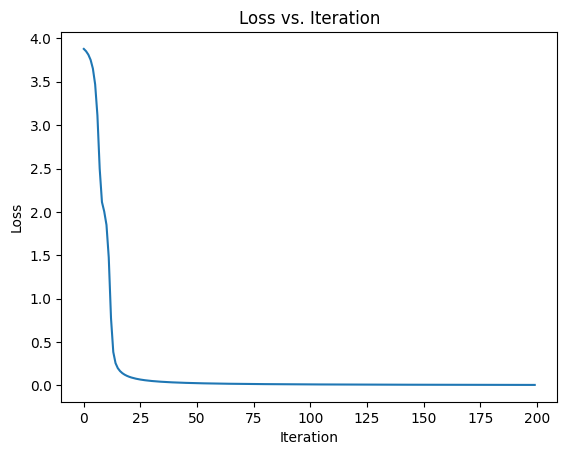

In [ ]:
plot_losses(losses)

### Build same model with pyTorch 

In [ ]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.3625147342681885
Epoch 10 loss: 0.011403700336813927
Epoch 20 loss: 7.816572178853676e-05
Epoch 30 loss: 4.876284265264985e-07

Prediction:
tensor([[ 0.9999],
        [-1.0000]])
Loss: 5.037124495288481e-09


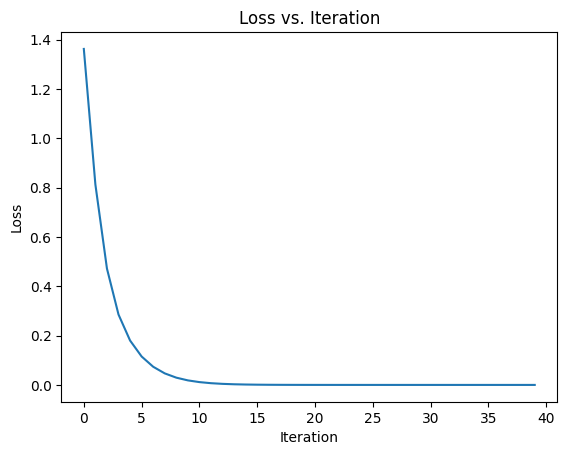

In [ ]:
plot_losses(losses)

In [ ]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[-0.3664,  0.2243, -0.5388],
        [-0.0938,  0.5044,  0.1338],
        [ 0.2833, -0.3626,  0.1457],
        [-0.0013,  0.5975,  0.3022]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[ 0.4790, -1.5929],
        [ 1.1917, -0.7189],
        [-0.6669,  1.2853],
        [ 1.4877, -0.4503]])

bT,  torch.Size([4, 1]):
tensor([[ 0.4833],
        [ 0.3588],
        [ 0.0864],
        [-0.0745]])

w * input + bT,  torch.Size([4, 2]):
tensor([[ 0.9623, -1.1096],
        [ 1.5505, -0.3601],
        [-0.5805,  1.3717],
        [ 1.4133, -0.5248]])

output,  torch.Size([4, 2]):
tensor([[ 0.7453, -0.8039],
        [ 0.9139, -0.3453],
        [-0.5230,  0.8791],
        [ 0.8882, -0.4814]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.3857, -0.276

In [ ]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [ ]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9999, -1.0000]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(6.0542e-09)

In [ ]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9999, -1.0000]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-6.7949e-05,  3.7909e-05]])
squared_difference: tensor([[4.6171e-09, 1.4371e-09]])


tensor(3.0271e-09)

In [ ]:
difference
len(squared_difference)

1

In [ ]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(3.0271e-09)

In [ ]:
torch.sum((output - torch.tensor(ys))**2)

tensor(6.0542e-09)